# Convergence Rate for Pure, First-Order Feedback on SO(2) and SO(3)

This is an attempt for simple, empirical / numeric checks for expected convergence rates against:
- feedback and integration as ODE for scalar Euclidean space $\mathbb{R}^1$ \
  (if I can't do this, then ain't no worth moving forward here)
- feedback via $\dot{\theta}$ and integration as ODE on $SO(2)$
- feedback via $\omega$ and integration as ODE on $SO(3)$

## Helper Stuff

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from so2_so3_helpers import (
    integrate,
    maxabs,
    flatten,
    unflatten,
    cat,
    split,
    normalize,
    rot2d,
    rot2d_jac,
    so2_angle,
    skew,
    unskew,
    axang,
    axang3,
    axang3_dot,
    to_axang3,
    so3_dist,
    assert_so3,
    rot_to_quat,
    quat_to_rot,
    quat_dot_to_angular,
    quat_conj,
    quat_prod,
    quat_to_axang,
)

## Sanity $\mathbb{R}^1$ Check

Dirt simple, coordinate $x$, with $x_0 \ne 0$, controller and solution should be

\begin{align*}
    \dot{x} &= -x \\
    x(t) &= x_0\ \text{exp}^{-t}
\end{align*}

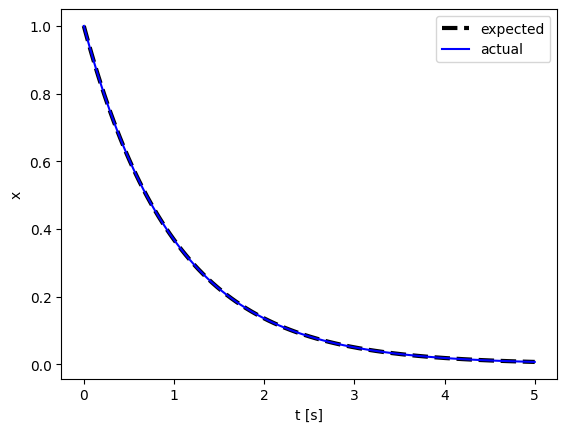

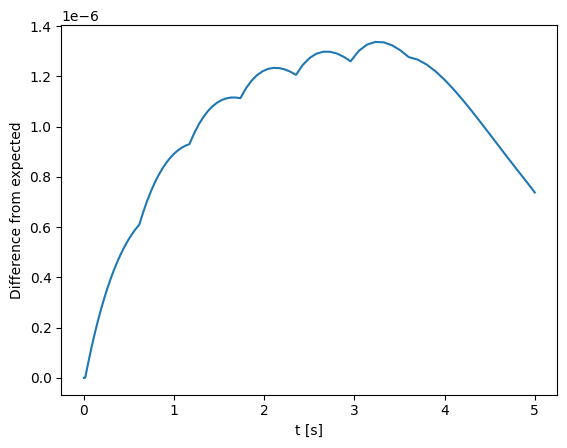

In [2]:
x0 = 1.0
q0 = [x0]

def calc_x_expected(t):
    x = x0 * np.exp(-t)
    return x

def q_to_x(q):
    x, = q
    return x

def calc_qd(q):
    x = q_to_x(q)
    x_err = x
    xd = -x_err
    qd = [xd]
    return qd

ts, q_as = integrate(q0=q0, calc_qd=calc_qd, tf=5.0)
x_as = [q_to_x(q_a) for q_a in q_as]
x_es = [calc_x_expected(t) for t in ts]
ts, x_as, x_es = map(np.asarray, (ts, x_as, x_es))

plt.figure()
plt.plot(ts, x_es, "k--", linewidth=3, label="expected")
plt.plot(ts, x_as, "b-", label="actual")
plt.xlabel("t [s]")
plt.ylabel("x")
plt.legend()

plt.figure()
plt.plot(ts, np.abs(x_as - x_es))
plt.xlabel("t [s]")
plt.ylabel("Difference from expected")
pass

## SO(2)

General rotation:
\begin{align*}
    c &= \cos(\theta) \\
    s &= \sin(\theta) \\
    R(\theta) &=
        \begin{bmatrix}
            c & -s \\
            s & c
        \end{bmatrix} \\
    \dot{R}(\theta, \dot{\theta}) &=
        \begin{bmatrix}
            -s & -c \\
            c & -s
        \end{bmatrix} \dot{\theta}
\end{align*}

Define simple first-order feedback with expected closed-form solution:
\begin{align*}
    \dot{\theta} &= -\theta \\
    \theta(t) &= \theta_0\ \text{exp}^{-t}
\end{align*}

But for kicks and giggles, integrate against $SO(2)$ via coordinate change as
\begin{align*}
    R(t) = \int \dot{R}\left(\theta, \dot{\theta}\right) \ dt
\end{align*}

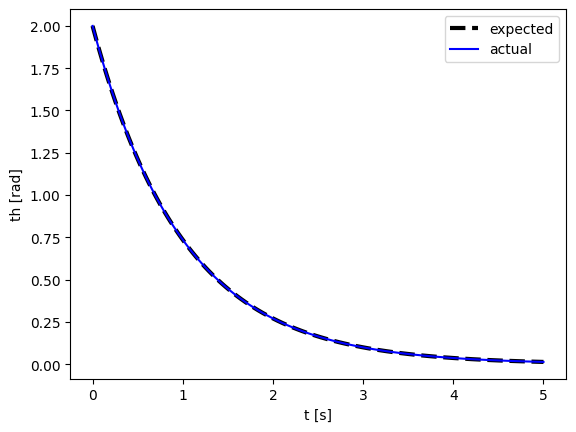

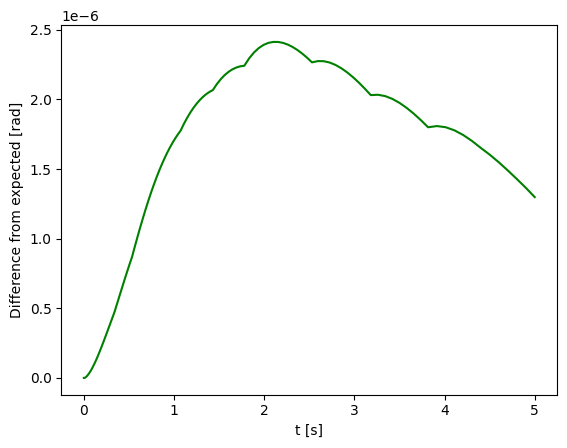

In [3]:
theta0 = 2.0
R0 = rot2d(theta0)
q0 = flatten(R0)

def calc_th_expected(t):
    theta = theta0 * np.exp(-t)
    return theta

def q_to_th(q):
    R = unflatten(q)
    so2_tol = 1e-5
    so2_err = R @ R.T - np.eye(2)
    assert maxabs(so2_err) < so2_tol, so2_err
    return so2_angle(R)

def calc_qd(q):
    R = unflatten(q)
    th = so2_angle(R)
    th_err = th
    thd = -th_err
    Rd = rot2d_jac(th) * thd
    qd = flatten(Rd)
    return qd

ts, q_as = integrate(q0=q0, calc_qd=calc_qd, tf=5.0)
th_as = [q_to_th(q_a) for q_a in q_as]
th_es = [calc_th_expected(t) for t in ts]
ts, th_as, th_es = map(np.asarray, (ts, th_as, th_es))

plt.figure()
plt.plot(ts, th_es, "k--", linewidth=3, label="expected")
plt.plot(ts, th_as, "b-", label="actual")
plt.xlabel("t [s]")
plt.ylabel("th [rad]")
plt.legend()

plt.figure()
plt.plot(ts, np.abs(th_as - th_es), "g")
plt.xlabel("t [s]")
plt.ylabel("Difference from expected [rad]")
pass

## SO(3)

### References

- [MLS] Murray, Richard M., Zexiang Li, and S. Shankar Sastry. \
   A Mathematical Introduction to Robotic Manipulation. 1st ed. CRC Press, 2017. \
   https://doi.org/10.1201/9781315136370. \
   <http://www.cds.caltech.edu/~murray/books/MLS/pdf/mls94-complete.pdf>

- [MITI] Mitiguy, Paul. \
  Advanced Dynamics & Motion Simulation: For Professional Engineers and Scientists (Graduate Work); 3D, Computational, Guided. \
  Prodigy Press, 2021. \
  <http://www.motiongenesis.com/MGWebSite/MGTextbooks/TextbookAdvancedDynamicsAndMotionSimulation.html>

- [LLM] Lee, Taeyoung, Melvin Leok, and N. Harris McClamroch. \
  “Control of Complex Maneuvers for a Quadrotor UAV Using Geometric Methods on SE(3).” arXiv, March 9, 2010. \
  https://doi.org/10.48550/arXiv.1003.2005.

- [ASW] Akhtar, Adeel, Sajid Saleem, and Steven L. Waslander. \
  “Feedback Linearizing Controllers on SO(3) Using a Global Parametrization.” \
  In 2020 American Control Conference (ACC), 1441–46, 2020. \
  https://doi.org/10.23919/ACC45564.2020.9147963.

- [A] Akhtar, Adeel. \
  “Nonlinear and Geometric Controllers for Rigid Body Vehicles.” Doctoral Thesis, \
  University of Waterloo, 2018. \
  https://uwspace.uwaterloo.ca/handle/10012/14006.

- [SDA] Solà, Joan, Jeremie Deray, and Dinesh Atchuthan. \
  “A Micro Lie Theory for State Estimation in Robotics.” \
  arXiv, December 8, 2021. https://doi.org/10.48550/arXiv.1812.01537.

- [S] Solà, Joan. \
  "Quaternion kinematics for the error-state Kalman filter". \
  <https://www.iri.upc.edu/people/jsola/JoanSola/objectes/notes/kinematics.pdf>

#### Discussion stuff

[MLS] lota stuff, incl. nice compact section on SO(3) and exponential coordinates.

[MITI] lotsa stuff, incl. info on rotation representations, angular velocities, accelerations, and the frames in which you gotta consider em.

[LLM] has some convergence *bounds* regarding convergence of (second-order) feedback linearization on $SE(3)$, but it'd
be nice to vet this stuff. It's feedback control law is tested below in contrast to log-space stuff.

[ASW] does feedback linearization on SO(3) and provides explicit connection to log map in Eq. (10), and connects that
to time derivative of log map in [A], Eq. (6.8).

Found [SDA] via survey paper stuff (http://arxiv.org/abs/1711.03896), it's got some purty nice stuff on Lie manifolds.
However, didn't (quickly) see direct connection on time derivative of log map for use as feedback signal, but it did
go into details on finite difference on manifolds / tangent spaces and (I think) differential flatness.

Found [S] while searching to connect colleague's (Aditya Bhat) implementation of SO(3) error control via quaternions per Khatib's notes.

### General Setup

Per [LLM] and other peeps with that notation, let:

- $\hat{}: \mathbb{R}^3 \rightarrow so(3)$ produce skew matrices
- $^\vee: so(3) \rightarrow \mathbb{R}^3$ be its inverse

First, restate the standard relationship between $R \in \mathbb{R}^{3 \times 3}$, its time derivatives,
and angular velocities (*world frame* or *body frame*):

\begin{align*}
    & \text{(world frame)} \\
    \dot{R} &= {}^W\hat{\omega} R \\
    {}^W\hat{\omega} &= \dot{R} R^T \\
    \\
    & \text{(body frame)} \\
    \dot{R} &= R \ \ {}^B\hat{\omega} \\
    {}^B\hat{\omega} &= R^T \dot{R} \\
\end{align*}

Per [MLS], define exponential map as $R(\lambda, \theta)$ as in Eq. (2.14), where
$\lambda \in \mathbb{R}^3, |\lambda| = 1$,
$\theta \in \mathbb{R}$. \
Define log map as $\log(R)$ to recover exponential coordinates $\lambda \theta$ per Eq. (2.17), (2.18). \
Can use `AngleAxis` from Eigen, bound in Python via `pydrake`.

For control, we want to drive our actual orientation, $R_a(t)$, towards our desired orientation, $R_d(t)$. \
Using Kane's notation, assuming we're trying to drive frame B w.r.t. inertial world frame W, we can denote stuff more verbosely as
- $R_a = {}^{W}R^{B_a}$ (frame B's actual orientation w.r.t. world frmae W)
- $R_d = {}^{W}R^{B_d}$ (frame B's desired orientation w.r..t world frame W)

But for compactness, just using $R_a, R_d$.

Let $R_{a,0} = R(\lambda, \theta_0)$, for (what is hopefully a) constant $\lambda$ across this solution. \
Let $R_d = I$ for simplicity (similar to above cases of converging to origin / identity).

**Note**: Because the solution *should be* along a single axis, meaning feedback should only act along that axis,
and this axis is a eigenvector of the rotation matrix, then changing between world frame and body frame
*for this setup* shouldn't really matter 😬

Using this, we define the following first-order feedback and dynamics, with the expected solution:

\begin{align*}
    & \text{(world frame)} \\
    ^{W}\omega &= -e_R \\
    \dot{R} &= {}^W\hat{\omega} R \\
    \\
    & \text{(body frame)} \\
    ^{B}\omega &= -e_R \\
    \dot{R} &= R \ \ {}^B\hat{\omega} \\
    \\
    & \text{Expected Solution} \\
    \theta(t) &= \theta_0\ \text{exp}^{-t} \\
    R(t) &= R(\lambda, \theta(t))
\end{align*}

For plotting, we use the angle between rotations, $d(R_1, R_2) = |\log(R_1^T R_2)|$.

For feedback, we try out two (among *many*) options for feedback:

- Use log-space (`err_mode="log"`)
- Use [LLM]'s time-derivative of the trace (`err_mode="paper_llm"`)

### Rotation Differencing

The two setups below rely on differnce in rotations; here're the two options (I think),
where $R_\Delta$ provides the diff, and $R_\omega$ reorients the error into the desired frame

\begin{align*}
    & \text{(world frame - extrinsic)} \\
    R_\Delta &= R_a R_d^T \\
    R_\omega &= I \\
    \\
    & \text{(body frame - intrinsic)} \\
    R_\Delta &= R_d^T R_a \\
    R_\omega &= R_a^T R_d = R_\Delta^T \\
\end{align*}

### Log-space

\begin{align*}
    e_R &= R_\omega \log(R_\Delta)
\end{align*}

### [LLM]'s Formulation

Use adaptation of formulation as shown in [LLM], Eq. (10):

\begin{align*}
    & \text{(original)} \\
    e_R &= \frac{1}{2} \left( R_d^T R - R^T R_d \right)^\vee \\
    \\
    & \text{(adapted)} \\
    e_R &= \frac{1}{2} R_\omega \left( R_\Delta - R_\Delta ^T \right)^\vee
\end{align*}

Adapted by generalizing their usage of $R_d^T R$ as $R_\Delta$ (per above), inject re-expression via $R_\omega$,
to admit world-frame integration -- though see above about single-axis and eigenvector.

**TODO**(eric.cousineau): Er, the paper's convergence properties seem very sub-exponential. \
Should check to see if I messed something up, or these are their expected bounds.

Seems like their error metric from which they derive stuff, $\Psi(R, R_d): SO(3) \times SO(3) \rightarrow \mathbb{R}$, is missing the surrounding $\arccos(\cdot)$?

### Error Feedback on Quaternion

(TODO: This is super messy; should actually derive / find good source derivation for this.)

Using mapping from angular velocity (global frame) to quaternion rate, per Table 4 in [S].

\begin{align*}
    \mathbf{q} &= \begin{bmatrix} q_w & q_x & q_y & q_z \end{bmatrix} \\
    
    \mathbf{Q}_{\delta \theta}(\mathbf{q}) &= \frac{1}{2} \begin{bmatrix}
        -q_x & -q_y & -q_z \\
        q_w & q_z & -q_y \\
        -q_z & q_w & q_x \\
        q_y & -q_x & q_w
    \end{bmatrix} \\

    \mathbf{N}(\mathbf{q}) &= \mathbf{Q}_{\delta \theta}^{-1} = 4 \mathbf{Q}_{\delta \theta}^T
\end{align*}

However, I still don't know why exactly the error formulation is as follows:

\begin{align*}
    {}^{W}e_{R} = -\mathbf{N(\mathbf{q_a})} \mathbf{q_d}
\end{align*}

From below, it seems like this is also sub-exponential convergence for basic tracking?

Maybe needs unit quatnerion projection as Drake uses?

$\theta_0$ = 1, err_mode=log
  max_diff = 0.000665


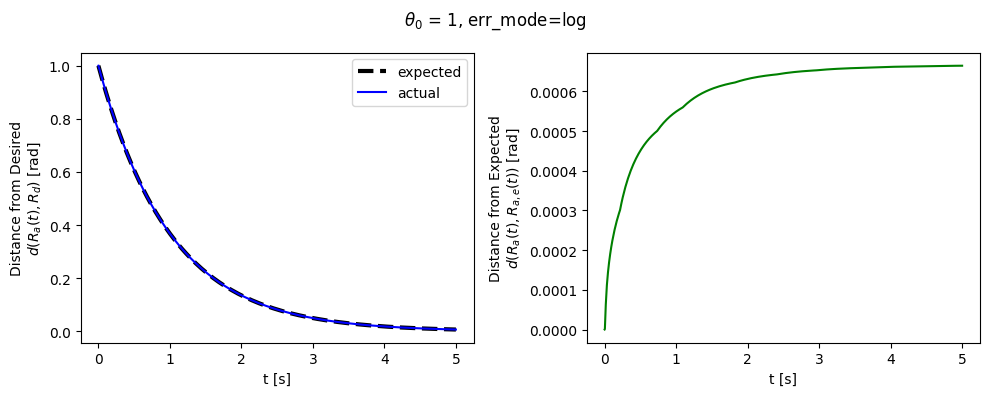

$\theta_0$ = 1, err_mode=quat_ematrix
  max_diff = 0.00813


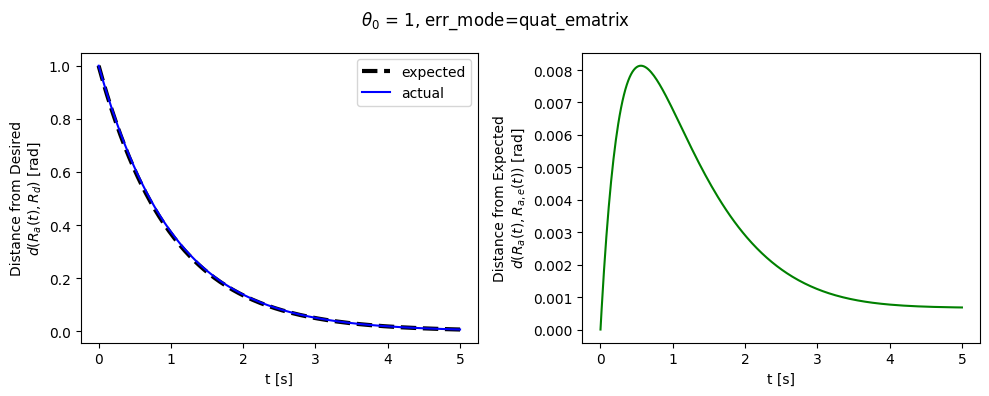

$\theta_0$ = 1, err_mode=quat_log
  max_diff = 0.000671


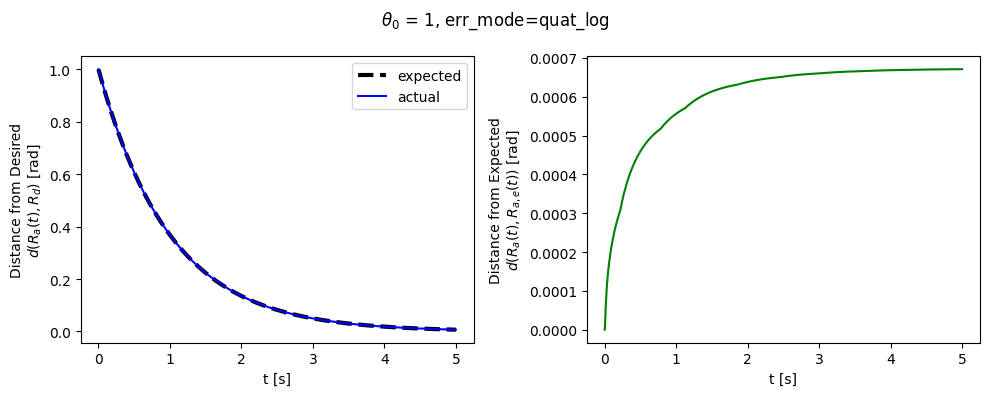

$\theta_0$ = 1, err_mode=paper_llm
  max_diff = 0.0338


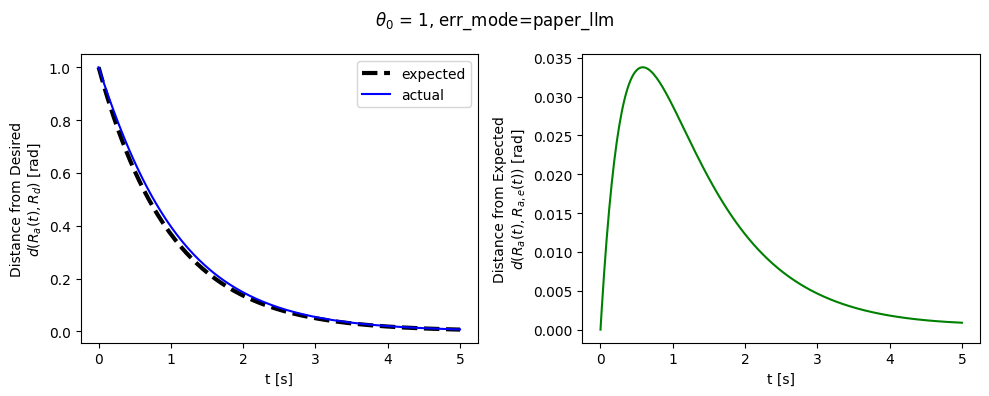

$\theta_0$ = 3.14, err_mode=log
  max_diff = 0.000946


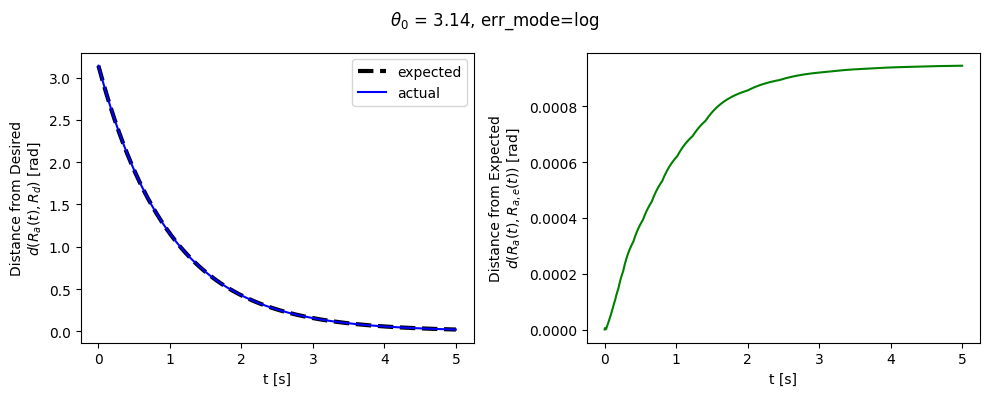

$\theta_0$ = 3.14, err_mode=quat_ematrix
  max_diff = 0.284


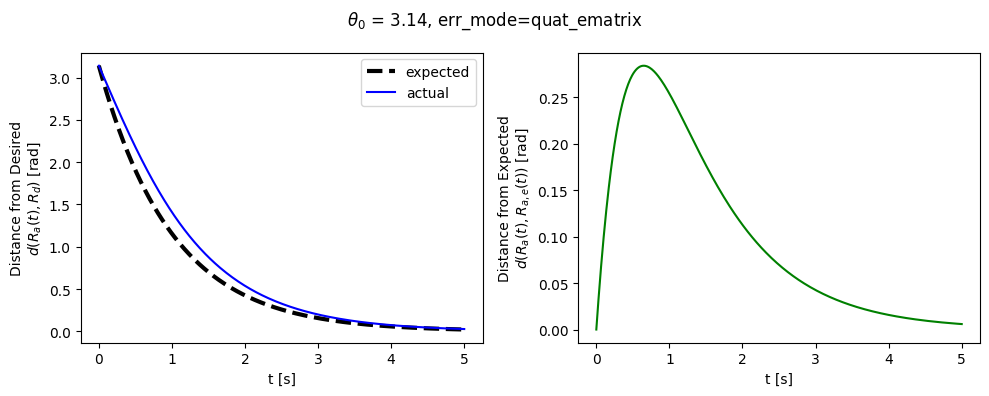

$\theta_0$ = 3.14, err_mode=quat_log
  max_diff = 0.00116


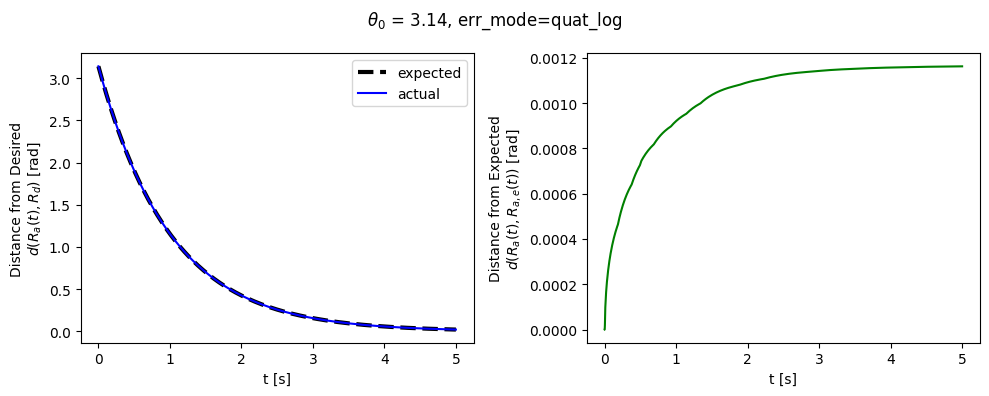

$\theta_0$ = 3.14, err_mode=paper_llm
  max_diff = 3.03


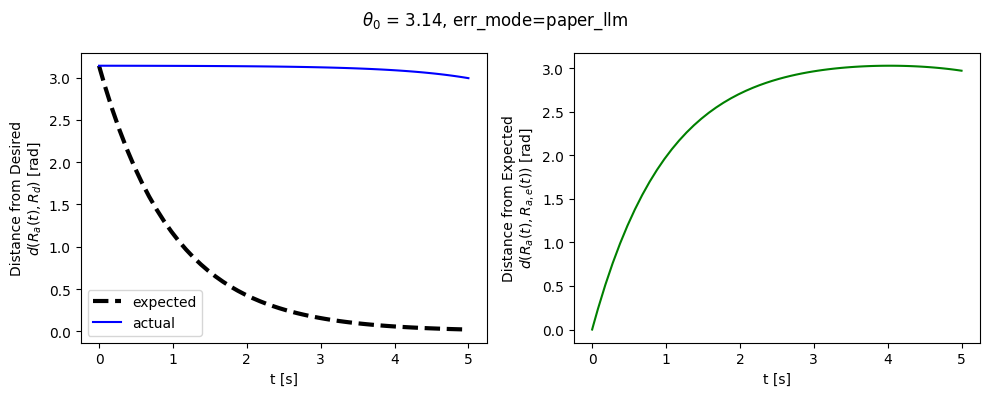

In [4]:
def check_so3(theta0, *, err_mode, use_world_frame):
    axis = normalize([0.2, 0.3, 0.4])
    R0 = axang(axis, theta0)
    q0 = flatten(R0)

    R_d = np.eye(3)

    def calc_R_expected(t):
        assert (R_d == np.eye(3)).all()
        theta = theta0 * np.exp(-t)
        R = axang(axis, theta)
        return R

    def q_to_R(q, *, check=True):
        R = unflatten(q)
        if check:
            so3_tol = 1e-4
            so3_err = R @ R.T - np.eye(3)
            assert maxabs(so3_err) < so3_tol, so3_err
        return R

    def rot_error_paper_llm(R_a, R_d):
        if use_world_frame:
            # Modify for world frame feedback.
            dR = R_a @ R_d.T
        else:
            dR = R_d.T @ R_a
        err_hat = (dR - dR.T) / 2
        return err_hat

    def rot_error_log(R_a, R_d):
        R = R_a @ R_d.T
        w = to_axang3(R)
        if use_world_frame:
            pass
        else:
            # TODO(eric.cousineau): Instead compute error different?
            # Maybe look at properties of adjoint against exponential coord?
            w = R_a.T @ w
        return skew(w)

    def rot_error_quat_ematrix(R_a, R_d):
        quat_a = rot_to_quat(R_a)
        quat_d = rot_to_quat(R_d)
        N = quat_dot_to_angular(quat_a)
        # Attempted to project w/ chain rule like Drake.
        # Doesn't seem right tho.
        # dnorm_dq = (np.eye(4) - quat_a @ quat_a.T)
        # N = N @ dnorm_dq
        w_err = -N @ quat_d
        return skew(w_err)

    def rot_error_quat_log(R_a, R_d):
        quat_a = rot_to_quat(R_a)
        quat_d = rot_to_quat(R_d)
        quat_e = quat_prod(quat_a, quat_conj(quat_d))
        w_err = quat_to_axang(quat_e)
        return skew(w_err)

    def calc_qd(q):
        R_a = q_to_R(q, check=False)
        if err_mode == "paper_llm":
            err_hat = rot_error_paper_llm(R_a, R_d)
        elif err_mode == "log":
            err_hat = rot_error_log(R_a, R_d)
        elif err_mode == "quat_ematrix":
            err_hat = rot_error_quat_ematrix(R_a, R_d)
        elif err_mode == "quat_log":
            err_hat = rot_error_quat_log(R_a, R_d)
        else:
            assert False
        w_hat = -err_hat
        if use_world_frame:
            Rd_a = w_hat @ R_a
        else:
            Rd_a = R_a @ w_hat
        qd = flatten(Rd_a)
        return qd

    ts, q_as = integrate(q0=q0, calc_qd=calc_qd, tf=5.0, accuracy=1e-6)
    R_as = [q_to_R(q_a) for q_a in q_as]
    R_es = [calc_R_expected(t) for t in ts]
    diffs = [so3_dist(R_a, R_e) for (R_a, R_e) in zip(R_as, R_es)]
    th_as = [so3_dist(R, R_d) for R in R_as]
    th_es = [so3_dist(R, R_d) for R in R_es]

    ts, diffs, th_as, th_es = map(np.asarray, (ts, diffs, th_as, th_es))

    max_diff = maxabs(diffs)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    plt.sca(axs[0])
    plt.plot(ts, th_es, "k--", linewidth=3, label="expected")
    plt.plot(ts, th_as, "b-", label="actual")
    plt.xlabel("t [s]")
    plt.ylabel("Distance from Desired\n$d(R_a(t), R_d)$ [rad]")
    plt.legend()

    plt.sca(axs[1])
    plt.plot(ts, diffs, "g")
    plt.xlabel("t [s]")
    plt.ylabel("Distance from Expected\n$d(R_a(t), R_{a,e}(t))$ [rad]")
    return max_diff

for theta0 in [1.0, np.pi - 0.001]:
    for err_mode in ["log", "quat_ematrix", "quat_log", "paper_llm"]:
        for use_world_frame in [True]: #, False]:
            title = f"$\\theta_0$ = {theta0:.3g}, err_mode={err_mode}" #, use_world_frame={use_world_frame}"
            print(title)
            max_diff = check_so3(
                theta0, err_mode=err_mode, use_world_frame=use_world_frame,
            )
            plt.suptitle(title)
            plt.tight_layout()
            print(f"  max_diff = {max_diff:.3g}")
            plt.show()

## Attempt to Empirically Validate Prop. 6.3.8 in [A]

*Note*: This is not checking via state-feedback. Instead, just checking time-derivatives similar to:

- [`sym_so3_notebook.ipynb`](./sym_so3_notebook.ipynb)
- [drake#18815](https://github.com/RobotLocomotion/drake/pull/18815) - premise was wrong (no bug in `MultibodyPlant`), but shows integration as second-order system

From the thesis, Proposition 6.3.8 (p. 102) states that:

\begin{align*}
  & \text{(body frame)} \\
  \dot{R} &= R \hat{\omega} \\
  \frac{d}{dt} \left[ \text{Log}(R) \right] &= R^T \dot{R} = \hat{\omega}
\end{align*}

### Setup

Define arbitrary time series $r(t) \in \mathbb{R}^3, \hat{r}(t) \in so(3)$, thus we can get $R(r(t)) \in SO(3)$ via exponential map. \
I want to check the equivalence between $\dot{r}(t)$ and $\omega(t)$ as computed via $\Omega(t) = R^T \dot{R}$

This is based on (naive?) assumption that
\begin{align*}
  \hat{r} &= \text{Log}(R) \\
  R &= \text{exp}^{\hat{r}}
\end{align*}
with bijection on the domain of $|r| < \pi$.

### Options

  1. Compute $\dot{R}(r, \dot{r})$, compute $\omega$ from this, and check if $\omega = \dot{r}$
  2. Compute $\dot{r}$, assume $\omega = \dot{r}$, and naively integrate via $\dot{R}$ and compare solution $R$ to expected $R(t)$ (similar to above)

Below checks both: Integrate forward on both (1) and (2) (with some add'l checks):
- $\dot{r}$ (direct) - to confirm trajectory + tangents work
- $\dot{R}_i = \dot{R}(r, \dot{r})$ - to confirm coordinate change works
- $\dot{R}_p = \hat{\omega} R_p\ ,\ \ \omega = \dot{r}$ - to see if proposition works

### Prelim Results

From below, seems like it doesn't yet match.

Bug in code? Maybe world-frame vs. body-frame stuff?

From [A], Def. 6.3.2 (from Sastry, Def. 8.18, p.365), $\text{Log}(X)$ is stated as well-defined near $I$,
so I assume that means it's a linear approximation at that point on the $SO(3)$ manifold.

Perhaps domain of Prop. 6.3.8 should be constrained by saying something like
"near global for constant-axis, locally approximate otherwise"?

single_axis=True


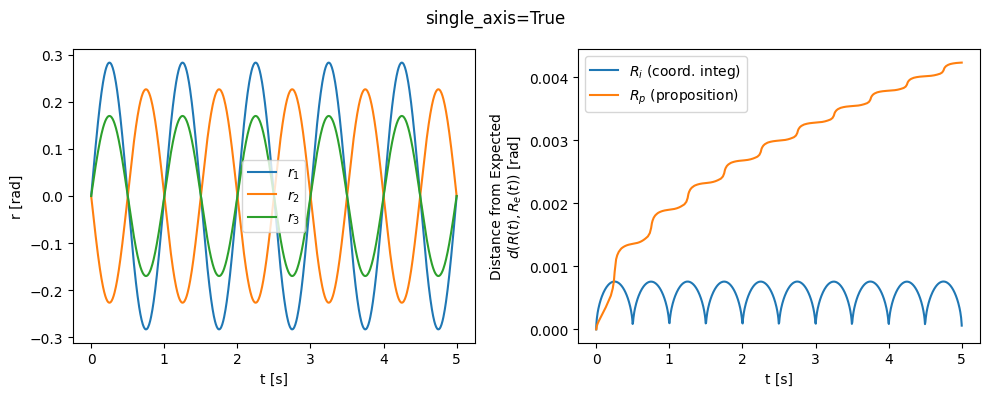

single_axis=False


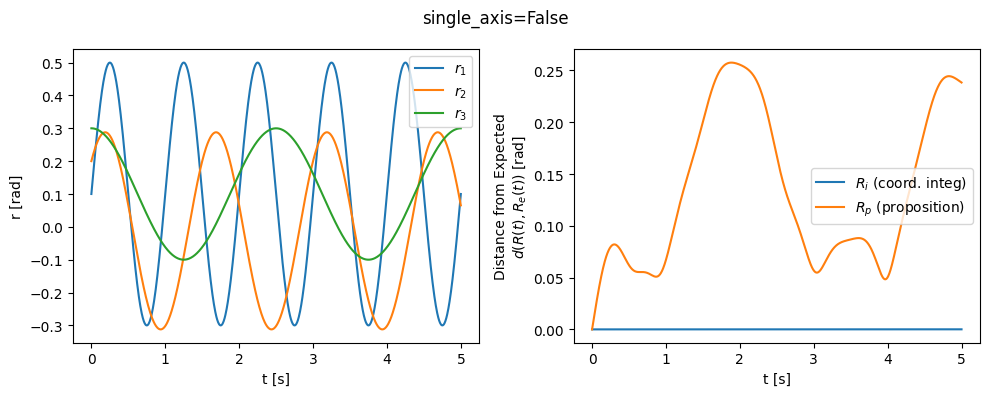

In [5]:
def calc_harmonics(t, Ts, T0_ratios):
    Ts = np.asarray(Ts)
    T0_ratios = np.asarray(T0_ratios)
    ws = 2 * np.pi / Ts
    x0 = T0_ratios * 2 * np.pi
    x = ws * t + x0
    xd = ws
    y = np.sin(x)
    y0 = np.sin(x0)
    yd = xd * np.cos(x)
    return y, y0, yd

def assert_bijective_so3(r, *, tol):
    R = axang3(r)
    r2 = to_axang3(R)
    err = maxabs(r - r2)
    assert err < tol, err


def check_so3(single_axis):
    if single_axis:
        n = normalize([0.5, -0.4, 0.3])
        r0 = np.zeros(3)
    else:
        r0 = np.array([0.1, 0.2,  0.3])

    def to_q(r, R_p, R_i):
        return cat(r, flatten(R_p), flatten(R_i))

    def from_q(q):
        num_r = len(r0)
        num_R = 9
        r, R_i, R_p = split(q, (num_r, num_R, num_R))
        R_i = unflatten(R_i)
        R_p = unflatten(R_p)
        return r, R_i, R_p

    def calc_r_rd_expected(t):
        if single_axis:
            # Restrict to R^1 subspace.
            As = 0.4
            Ts = [1.0]
            T0_ratios = [0.0]
            y, y0, yd = calc_harmonics(t, Ts, T0_ratios)
            y = y * n
            y0 = y0 * n
            yd = yd * n
        else:
            As = np.array([0.4, 0.3, 0.2])
            Ts = np.array([1.0, 1.5, 2.5])
            T0_ratios = np.array([0, 0.125, 0.25])
            y, y0, yd = calc_harmonics(t, Ts, T0_ratios)
        r = As * (y - y0) + r0
        rd = As * yd
        return r, rd

    def calc_qd(t, q, *, check=False):
        r_i, R_i, R_p = from_q(q)
        if check:
            so3_tol = 1e-4
            assert_so3(R_i, tol=so3_tol)
            assert_so3(R_p, tol=so3_tol)
            # Lazy empirical check for bijection on |r| < pi:
            # Ensure that we have a fixed point on exp. coord.
            assert_bijective_so3(r_i, tol=1e-10)
        r_e, rd_e = calc_r_rd_expected(t)
        rd_i = rd_e
        # Integrate with coord. change.
        Rd_i = axang3_dot(r_e, rd_e)
        # Integrate via (my interpretation of) proposition.
        w_p_hat = skew(rd_e)
        Rd_p = w_p_hat @ R_p
        # Pack derivatives.
        qd = to_q(rd_i, Rd_i, Rd_p)
        return qd

    def calc_R_expected(t):
        r, _ = calc_r_rd_expected(t)
        R = axang3(r)
        return R

    R0 = axang3(r0)
    q0 = to_q(r0, R_i=R0, R_p=R0)

    ts, qs = integrate(
        q0=q0, calc_qd=calc_qd, tf=5.0, pass_time=True, check=True, accuracy=1e-6
    )
    # Unpack.
    r_is = [from_q(q)[0] for q in qs]
    R_is = [from_q(q)[1] for q in qs]
    R_ps = [from_q(q)[2] for q in qs]
    # Expected.
    r_es = [calc_r_rd_expected(t)[0] for t in ts]
    R_es = [calc_R_expected(t) for t in ts]
    # Compute distances.
    r_i_diffs = [maxabs(r_i - r_e) for (r_i, r_e) in zip(r_is, r_es)]
    R_i_diffs = [so3_dist(R_i, R_e) for (R_i, R_e) in zip(R_is, R_es)]
    R_p_diffs = [so3_dist(R_p, R_e) for (R_p, R_e) in zip(R_ps, R_es)]

    ts, r_i_diffs, R_i_diffs, R_p_diffs = map(
        np.asarray, (ts, r_i_diffs, R_i_diffs, R_p_diffs)
    )

    # Make sure we spec'd the right signal.
    assert maxabs(r_i_diffs) < 1e-9

    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

    plt.sca(axs[0])
    plt.plot(ts, r_is)
    plt.xlabel("t [s]")
    plt.ylabel("r [rad]")
    plt.legend(["$r_1$", "$r_2$", "$r_3$"])

    plt.sca(axs[1])
    plt.plot(ts, R_i_diffs, label="$R_i$ (coord. integ)")
    plt.plot(ts, R_p_diffs, label="$R_p$ (proposition)")
    plt.xlabel("t [s]")
    plt.ylabel("Distance from Expected\n$d(R(t), R_e(t))$ [rad]")
    plt.legend()

for single_axis in [True, False]:
    title = f"single_axis={single_axis}"
    print(title)
    check_so3(single_axis)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()